In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.datasets import make_classification
from mlxtend.plotting import plot_decision_regions

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# Set display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Load data
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

### Data Exploration

In [4]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank.describe(include='number')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
bank.describe(exclude='number')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

### Majority Class Baseline

In [8]:
# Assign target and features
X = bank.drop(columns=['y', 'duration'])
y = bank['y'] == 'yes'

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 19), (8238, 19), (32950,), (8238,))

In [10]:
# Majority class baseline
y_train.value_counts(normalize=True)

False    0.887344
True     0.112656
Name: y, dtype: float64

### First Fast Model

In [11]:
# Encode categorical features
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [12]:
# Make pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
y_pred_proba = cross_val_predict(pipeline, X_train_encoded, y_train, cv=10, n_jobs=-1, method='predict_proba')[:,1]

In [13]:
threshold = 0.1
y_pred = y_pred_proba >= threshold

print(classification_report(y_train, y_pred))

pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'],
            index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

       False       0.95      0.82      0.88     29238
        True       0.32      0.65      0.42      3712

   micro avg       0.80      0.80      0.80     32950
   macro avg       0.63      0.74      0.65     32950
weighted avg       0.88      0.80      0.83     32950



,Predicted Negative,Predicted Positive
Actual Negative,24011,5227
Actual Positive,1301,2411


In [14]:
# Accuracy Score
print('Accuracy Score:', accuracy_score(y_train, y_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_pred_proba))

Accuracy Score: 0.8018816388467375
ROC AUC Score: 0.7885338468139597


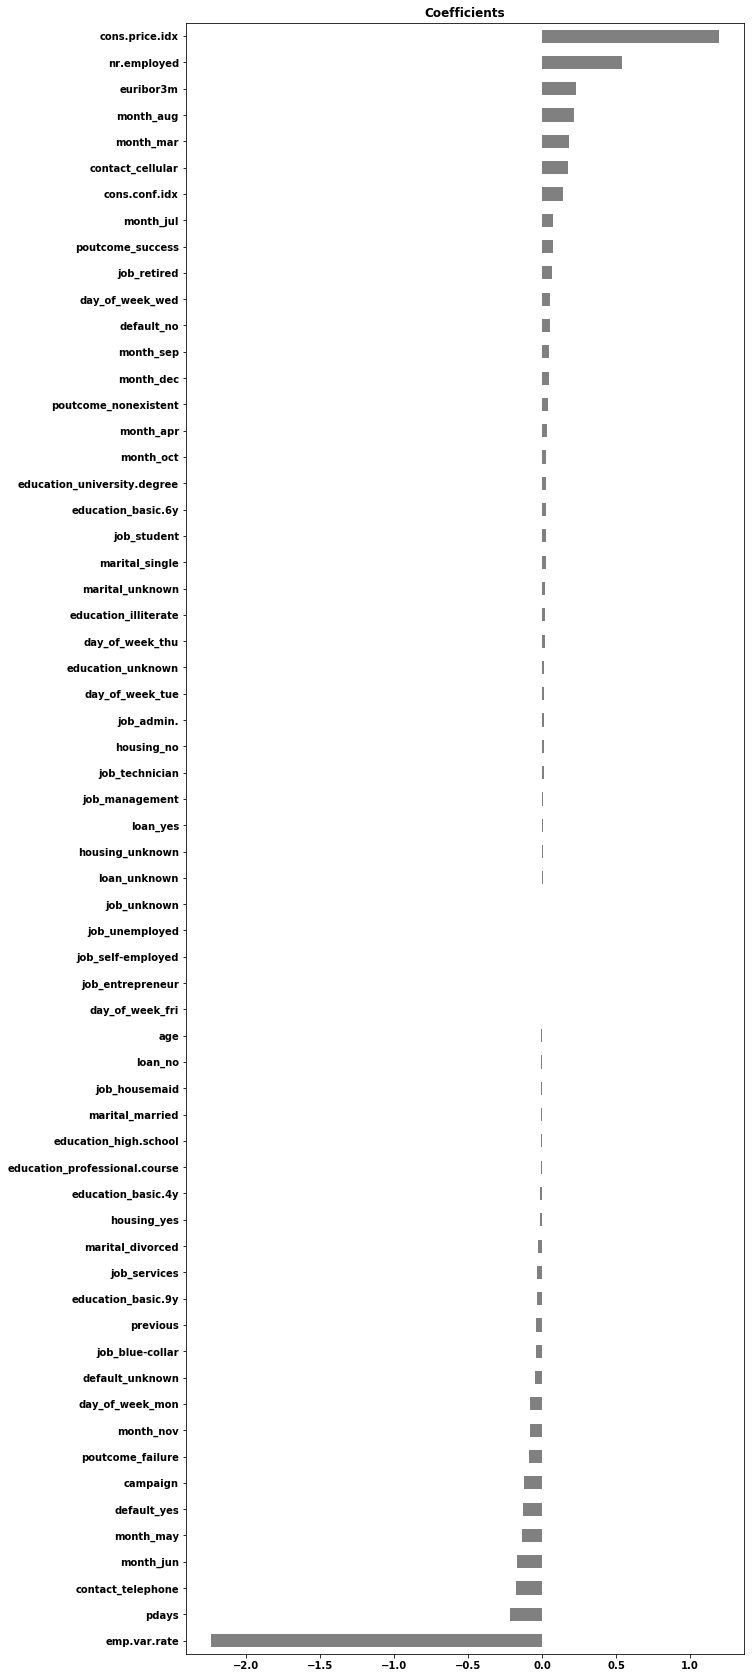

In [15]:
# Visualize Coefficients---------------------------
pipeline.fit(X_train_encoded, y_train)
plt.figure(figsize=(10, 30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = X_train_encoded.columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

### Dealing with Categorical Features

In [16]:
# create df copy
bank_copy = bank.copy()

# Bin less represented categories as 'other'
# jobs = {'retired': 0, 'entrepreneur': 3, 'self-employed': 2, 'housemaid': 1, 'technician': 6, 'blue-collar': 7,
#         'unemployed': 0, 'student': 0, 'unknown': 0, 'management': 4, 'services': 5, 'admin.': 8}
# bank_copy['job'] = bank_copy['job'].replace(jobs)

In [328]:
# week_days = {'thu': 4, 'mon': 1, 'wed': 3, 'tue': 2, 'fri': 5}
# bank_copy['day_of_week'] = bank_copy['day_of_week'].replace(week_days)

In [316]:
# educations = {'illiterate': 0, 'unknown': 0, 'basic.6y': 1, 'basic.4y': 1, 'basic.9y': 1, 'professional.course': 3,
#              'high.school': 2, 'university.degree': 4}
# bank_copy['education'] = bank_copy['education'].replace(educations)

In [317]:
# marital_status = {'unknown': -1, 'divorced': 0, 'single': 1, 'married': 2}
# bank_copy['marital'] = bank_copy['marital'].replace(marital_status)

In [318]:
# num_days = {999: -1}
# bank_copy['pdays'] = bank_copy['pdays'].replace(num_days)

In [329]:
# months = {'may': 5, 'jul': 7, 'aug': 8, 'jun': 6, 'nov': 11, 'apr': 4, 'oct': 10, 'sep': 9, 'mar': 3, 'dec': 12}
# bank_copy['month'] = bank_copy['month'].replace(months)

In [351]:
# binary_replace = {'yes': 1, 'no': 0, 'unknown': -1}
# bank_copy['default'] = bank_copy['default'].replace(binary_replace)
# bank_copy['housing'] = bank_copy['housing'].replace(binary_replace)
# bank_copy['loan'] = bank_copy['loan'].replace(binary_replace)

In [321]:
# outcome = {'nonexistent': -1, 'failure': 0, 'success': 1}
# bank_copy['poutcome'] = bank_copy['poutcome'].replace(outcome)

In [322]:
# phone_type = {'cellular': 0, 'telephone': 1}
# bank_copy['contact'] = bank_copy['contact'].replace(phone_type)

In [330]:
bank_copy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,1,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,5,1,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,5,1,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,5,1,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,5,1,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Re-Run Model with New Features

In [17]:
# Assign to X, y
X = bank_copy.drop(columns=['y', 'duration', 'loan', 'housing', 'age', 'job', 'education'])
y = bank_copy['y'] == 'yes'

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')[:,1]

In [24]:
# Classification report and confusion matrix
threshold = 0.5
y_pred = y_pred_proba >= threshold
print(classification_report(y_train, y_pred))
pd.DataFrame(confusion_matrix(y_train, y_pred),
            columns=['Predicted Negative', 'Predicted Positive'],
            index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     29238
        True       0.66      0.22      0.33      3712

   micro avg       0.90      0.90      0.90     32950
   macro avg       0.79      0.60      0.64     32950
weighted avg       0.88      0.90      0.88     32950



,Predicted Negative,Predicted Positive
Actual Negative,28818,420
Actual Positive,2881,831


In [19]:
# Scores
print('Accuracy Score:', accuracy_score(y_train, y_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_pred_proba))

Accuracy Score: 0.7974810318664644
ROC AUC Score: 0.7899068681065146


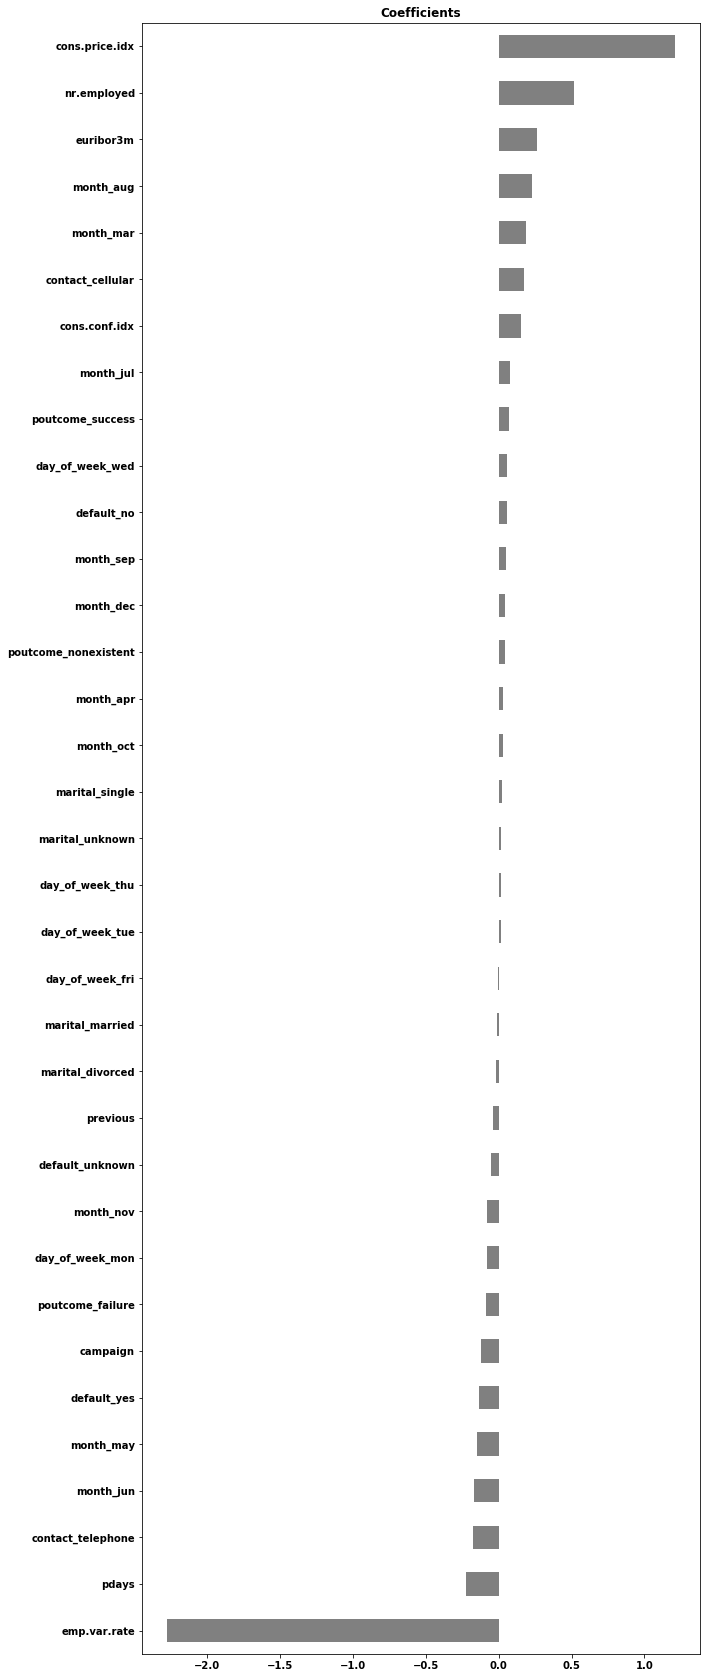

In [20]:
# Visualize Coefficients
pipeline.fit(X_train, y_train)
plt.figure(figsize=(10, 30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

Area under the Receiver Operating Characteristic curve: 0.7899068681065146


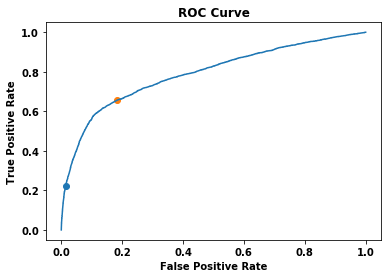

In [25]:
# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:',
     roc_auc_score(y_train, y_pred_proba))

# When threshold = 0.5
false_positives = 420
true_positives = 831
false_negatives = 2881
true_negatives = 28818
actual_positives = true_positives + false_negatives
actual_negatives = true_negatives + false_positives
false_positive_rate = false_positives / actual_negatives
true_positive_rate = true_positives/ actual_positives
plt.scatter(false_positive_rate, true_positive_rate)

# When threshold = 0.1
false_positives = 5399
true_positives = 2438
false_negatives = 1274
true_negatives = 23839
actual_positives = true_positives + false_negatives
actual_negatives = true_negatives + false_positives
false_positive_rate = false_positives / actual_negatives
true_positive_rate = true_positives / actual_positives
plt.scatter(false_positive_rate, true_positive_rate);